# 模型预测控制

在深度强化学习领域下，**基于模型**（model-based）的方法通常用神经网络学习一个环境模型，然后利用该环境模型来帮助智能体训练和决策。**模型预测控制**（model predictive control，MPC）算法并不构建一个显式的策略，只根据环境模型来选择当前步要采取的动作。

让我们用一个形象的比喻来帮助理解模型预测控制方法。假设我们在下围棋，现在根据棋盘的布局，我们要选择现在落子的位置。一个优秀的棋手会根据目前局势来推演落子几步可能发生的局势，然后选择局势最好的一种情况来决定当前落子位置。

MPC 方法在每次采取动作时，首先会生成一些候选动作序列，然后根据当前状态来确定每一条候选序列能得到多好的结果，最终选择结果最好的那条动作序列的第一个动作来执行。因此，在使用 MPC 方法时，主要在两个过程中迭代，一是根据历史数据学习环境模型，二是在和真实环境交互过程中用环境模型来选择动作。

模型预测控制（MPC）方法有着其独特的优势，例如它不用构建和训练策略，可以更好地利用环境，可以进行更长步数的规划。但是 MPC 也有其局限性，例如模型在多步推演之后的准确性会大大降低，简单的控制策略对于复杂系统可能不够。MPC 还有一个更为严重的问题，即每次计算动作的复杂度太大，这使其在一些策略及时性要求较高的系统中应用就变得不太现实。

In [1]:
import numpy as np
from scipy.stats import truncnorm
import gym
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import collections
import matplotlib.pyplot as plt
from typing import Tuple

## 1. 打靶法

MPC 方法中的一个关键是如何生成一些候选动作序列，候选动作生成的好坏将直接影响到 MPC 方法得到的动作。生成候选动作序列的过程我们称为**打靶**（shooting）。

- **随机打靶法**（random shooting method）的做法便是随机生成条动作序列，即在生成每条动作序列的每一个动作时，都是从动作空间中随机采样一个动作，最终组合成N条长度为H的动作序列。

- **交叉熵方法**（cross entropy method，CEM）是一种进化策略方法，它的核心思想是维护一个带参数的分布，根据每次采样的结果来更新分布中的参数，使得分布中能获得较高累积奖励的动作序列的概率比较高。相比于随机打靶法，交叉熵方法能够利用之前采样到的比较好的结果，在一定程度上减少采样到一些较差动作的概率，从而使得算法更加高效。

In [2]:
class CEM:
    """交叉熵方法"""
    def __init__(self, 
            n_sequence:int, elite_ratio:float, fake_env, 
            upper_bound:float, lower_bound:float
        ):
        self.n_sequence = n_sequence
        self.elite_ratio = elite_ratio
        self.upper_bound = upper_bound
        self.lower_bound = lower_bound
        self.fake_env = fake_env

    def optimize(self, 
            state:np.ndarray, init_mean:np.ndarray, init_var:np.ndarray
        ) -> np.ndarray:
        mean, var = init_mean, init_var
        X = truncnorm(-2, 2, loc=np.zeros_like(mean), scale=np.ones_like(var))
        state = np.tile(state, (self.n_sequence, 1))

        for _ in range(5):
            lb_dist, ub_dist = mean - self.lower_bound, self.upper_bound - mean
            constrained_var = np.minimum(
                                np.minimum(
                                    np.square(lb_dist / 2), np.square(ub_dist / 2)
                                ), var
                            )
            # 生成动作序列
            action_sequences = [X.rvs() for _ in range(self.n_sequence)
                            ] * np.sqrt(constrained_var) + mean
            # 计算每条动作序列的累积奖励
            returns = self.fake_env.propagate(state, action_sequences)[:, 0]
            # 选取累积奖励最高的若干条动作序列
            elites = action_sequences[np.argsort(returns)
                                ][-int(self.elite_ratio * self.n_sequence):]
            new_mean = np.mean(elites, axis=0)
            new_var = np.var(elites, axis=0)
            # 更新动作序列分布
            mean = 0.1 * mean + 0.9 * new_mean
            var = 0.1 * var + 0.9 * new_var

        return mean

## 2. PETS 算法

带有轨迹采样的概率集成（probabilistic ensembles with trajectory sampling，PETS）是一种使用 MPC 的基于模型的强化学习算法。在 PETS 中，环境模型采用了集成学习的方法，即会构建多个环境模型，然后用这多个环境模型来进行预测，最后使用 CEM 进行模型预测控制。

在强化学习中，与智能体交互的环境是一个动态系统，所以拟合它的环境模型也通常是一个动态模型。我们通常认为一个系统中有两种不确定性，分别是**偶然不确定性**（aleatoric uncertainty）和**认知不确定性**（epistemic uncertainty）。偶然不确定性是由于系统中本身存在的随机性引起的，而认知不确定性是由“见”过的数据较少导致的自身认知的不足而引起的。

我们定义环境模型的输出为一个高斯分布，用来捕捉偶然不确定性，用**集成**（ensemble）方法来捕捉认知不确定性。具体而言，我们构建若干个网络框架一样的神经网络，它们的输入都是状态动作对，输出都是下一个状态的高斯分布的均值向量和协方差矩阵。但是它们的参数采用不同的随机初始化方式，并且当每次训练时，会从真实数据中随机采样不同的数据来训练。有了环境模型的集成后，MPC 算法会用其来预测奖励和下一个状态。具体来说，每一次预测会从这些模型中挑选一个来进行预测，因此一条轨迹的采样会使用到多个环境模型。

首先，为了搭建这样一个较为复杂的模型，我们定义模型中每一层的构造。在定义时就必须考虑每一层都是一个集成。

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class Swish(nn.Module):
    ''' Swish激活函数 '''
    def __init__(self):
        super().__init__()

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return x * torch.sigmoid(x)


def init_weights(m:nn.Module):
    ''' 初始化模型权重 '''
    def truncated_normal_init(
            t:torch.Tensor, mean:float=0.0, std:float=0.01
        ) -> torch.Tensor:
        torch.nn.init.normal_(t, mean=mean, std=std)
        while True:
            cond = (t < mean - 2 * std) | (t > mean + 2 * std)
            if not torch.sum(cond):
                break
            t = torch.where(
                cond,
                torch.nn.init.normal_(torch.ones(t.shape, device=device),
                                      mean=mean, std=std
                ), t
            )
        return t

    if type(m) == nn.Linear or isinstance(m, FCLayer):
        truncated_normal_init(m.weight, std=1 / (2 * np.sqrt(m._input_dim)))
        m.bias.data.fill_(0.0)


class FCLayer(nn.Module):
    ''' 集成之后的全连接层 '''
    def __init__(self, 
            input_dim:int, output_dim:int, ensemble_size:int, activation:nn.Module
        ):
        super().__init__()
        self._input_dim, self._output_dim = input_dim, output_dim
        self.weight = nn.Parameter(
                        torch.Tensor(ensemble_size, input_dim, output_dim).to(device)
                    )
        self._activation = activation
        self.bias = nn.Parameter(
                        torch.Tensor(ensemble_size, output_dim).to(device)
                    )

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self._activation(
            torch.add(torch.bmm(x, self.weight), self.bias[:, None, :])
        )

接着，使用高斯分布的概率模型来定义一个集成模型。

In [4]:
class EnsembleModel(nn.Module):
    ''' 环境模型集成 '''
    def __init__(self,
            state_dim:int, action_dim:int, ensemble_size:int=5,
            learning_rate:float=1e-3
        ):
        super().__init__()
        # 输出包括均值和方差,因此是状态与奖励维度之和的两倍
        self._output_dim = (state_dim + 1) * 2
        self._max_logvar = nn.Parameter(
                                (torch.ones((1, self._output_dim // 2)).float() / 2
                                ).to(device),
                                requires_grad=False
                            )
        self._min_logvar = nn.Parameter(
                                (-torch.ones((1, self._output_dim // 2)).float() * 10
                                ).to(device),
                                requires_grad=False
                            )
        self.layer1 = FCLayer(state_dim + action_dim, 200, ensemble_size, Swish())
        self.layer2 = FCLayer(200, 200, ensemble_size, Swish())
        self.layer3 = FCLayer(200, 200, ensemble_size, Swish())
        self.layer4 = FCLayer(200, 200, ensemble_size, Swish())
        self.layer5 = FCLayer(200, self._output_dim, ensemble_size, nn.Identity())
        self.apply(init_weights)  # 初始化环境模型中的参数
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, 
            x:torch.Tensor, return_log_var:bool=False
        ) -> Tuple[torch.Tensor, torch.Tensor]:
        ret = self.layer5(
                self.layer4(self.layer3(self.layer2(self.layer1(x))))
            )
        mean = ret[:, :, :self._output_dim // 2]
        # 在PETS算法中,将方差控制在最小值和最大值之间
        logvar = self._max_logvar - \
                    F.softplus(self._max_logvar - ret[:, :, self._output_dim // 2:])
        logvar = self._min_logvar + \
                    F.softplus(logvar - self._min_logvar)
        return mean, logvar if return_log_var else torch.exp(logvar)

    def loss(self, 
            mean:torch.Tensor, logvar:torch.Tensor, labels:torch.Tensor, 
            use_var_loss:bool=True
        ) -> Tuple[torch.Tensor, torch.Tensor]:
        inverse_var = torch.exp(-logvar)
        if use_var_loss:
            mse_loss = torch.mean(
                        torch.mean(
                            torch.pow(mean - labels, 2) * inverse_var, 
                            dim=-1
                        ),
                        dim=-1
                    )
            var_loss = torch.mean(torch.mean(logvar, dim=-1), dim=-1)
            total_loss = torch.sum(mse_loss) + torch.sum(var_loss)
        else:
            mse_loss = torch.mean(torch.pow(mean - labels, 2), dim=(1, 2))
            total_loss = torch.sum(mse_loss)
        return total_loss, mse_loss

    def train(self, loss:torch.Tensor):
        self.optimizer.zero_grad()
        loss += 0.01 * torch.sum(self._max_logvar) - \
                0.01 * torch.sum(self._min_logvar)
        loss.backward()
        self.optimizer.step()

接下来，我们定义一个EnsembleDynamicsModel的类，把模型集成的训练设计得更加精细化。具体而言，我们并不会选择模型训练的轮数，而是在每次训练的时候将一部分数据单独取出来，用于验证模型的表现，在 5 次没有获得表现提升时就结束训练。

In [5]:
class EnsembleDynamicsModel:
    ''' 环境模型集成,加入精细化的训练 '''
    def __init__(self, state_dim:int, action_dim:int, num_network:int=5):
        self._num_network = num_network
        self._state_dim, self._action_dim = state_dim, action_dim
        self.model = EnsembleModel(state_dim, action_dim,
                                   ensemble_size=num_network)
        self._epoch_since_last_update = 0

    def train(self,
            inputs:torch.Tensor, labels:torch.Tensor,
            batch_size:int=64, holdout_ratio:float=0.1, max_iter:int=20
        ):
        # 设置训练集与验证集
        permutation = np.random.permutation(inputs.shape[0])
        inputs, labels = inputs[permutation], labels[permutation]
        num_holdout = int(inputs.shape[0] * holdout_ratio)
        train_inputs, train_labels = inputs[num_holdout:], labels[num_holdout:]
        holdout_inputs, holdout_labels = inputs[:num_holdout], labels[:num_holdout]
        holdout_inputs = torch.from_numpy(holdout_inputs).float().to(device)
        holdout_labels = torch.from_numpy(holdout_labels).float().to(device)
        holdout_inputs = holdout_inputs[None, :, :].repeat([self._num_network, 1, 1])
        holdout_labels = holdout_labels[None, :, :].repeat([self._num_network, 1, 1])

        # 保留最好的结果
        self._snapshots = {i: (None, 1e10) for i in range(self._num_network)}

        for epoch in itertools.count():
            # 定义每一个网络的训练数据
            train_index = np.vstack([
                            np.random.permutation(train_inputs.shape[0])
                            for _ in range(self._num_network)
                        ])
            # 所有真实数据都用来训练
            for batch_start_pos in range(0, train_inputs.shape[0], batch_size):
                batch_index = train_index[:, 
                                batch_start_pos:batch_start_pos + batch_size]
                train_input = torch.from_numpy(
                                train_inputs[batch_index]).float().to(device)
                train_label = torch.from_numpy(
                                train_labels[batch_index]).float().to(device)

                mean, logvar = self.model(train_input, return_log_var=True)
                loss, _ = self.model.loss(mean, logvar, train_label)
                self.model.train(loss)

            with torch.no_grad():
                mean, logvar = self.model(holdout_inputs, return_log_var=True)
                _, holdout_losses = self.model.loss(
                                        mean, logvar, holdout_labels,
                                        use_var_loss=False
                                    )
                holdout_losses = holdout_losses.cpu()
                break_condition = self._save_best(epoch, holdout_losses)
                if break_condition or epoch > max_iter:  # 结束训练
                    break

    def _save_best(self, 
            epoch:int, losses:torch.Tensor, threshold:float=0.1
        ) -> bool:
        updated = False
        for i in range(len(losses)):
            current = losses[i]
            _, best = self._snapshots[i]
            improvement = (best - current) / best
            if improvement > threshold:
                self._snapshots[i] = (epoch, current)
                updated = True
        self._epoch_since_last_update = 0 if updated \
                                        else self._epoch_since_last_update + 1
        return self._epoch_since_last_update > 5

    def predict(self, 
            inputs:torch.Tensor, batch_size:int=64
        ) -> Tuple[np.ndarray, np.ndarray]:
        mean, var = [], []
        for i in range(0, inputs.shape[0], batch_size):
            input = torch.from_numpy(
                        inputs[i:min(i + batch_size, inputs.shape[0])]
                    ).float().to(device)
            cur_mean, cur_var = self.model(
                                    input[None, :, :].repeat([self._num_network, 1, 1]),
                                    return_log_var=False
                                )
            mean.append(cur_mean.detach().cpu().numpy())
            var.append(cur_var.detach().cpu().numpy())
        return np.hstack(mean), np.hstack(var)

有了环境模型之后，我们就可以定义一个FakeEnv，主要用于实现给定状态和动作，用模型集成来进行预测。该功能会用在 MPC 算法中。

In [6]:
class FakeEnv:
    def __init__(self, model:EnsembleDynamicsModel):
        self.model = model

    def step(self, 
            obs:torch.Tensor, act:torch.Tensor
        ) -> Tuple[np.ndarray, np.ndarray]:
        inputs = np.concatenate((obs, act), axis=-1)
        ensemble_model_means, ensemble_model_vars = self.model.predict(inputs)
        ensemble_model_means[:, :, 1:] += obs.numpy()
        ensemble_model_stds = np.sqrt(ensemble_model_vars)
        ensemble_samples = ensemble_model_means + \
                        np.random.normal(size=ensemble_model_means.shape
                        ) * ensemble_model_stds

        num_models, batch_size, _ = ensemble_model_means.shape
        models_to_use = np.random.choice(
                            [i for i in range(self.model._num_network)], 
                            size=batch_size
                        )
        batch_inds = np.arange(0, batch_size)
        samples = ensemble_samples[models_to_use, batch_inds]
        rewards, next_obs = samples[:, :1], samples[:, 1:]
        return rewards, next_obs

    def propagate(self, obs:np.ndarray, actions:np.ndarray) -> np.ndarray:
        with torch.no_grad():
            obs = np.copy(obs)
            total_reward = np.expand_dims(np.zeros(obs.shape[0]), axis=-1)
            obs, actions = torch.as_tensor(obs), torch.as_tensor(actions)
            for i in range(actions.shape[1]):
                action = torch.unsqueeze(actions[:, i], 1)
                rewards, next_obs = self.step(obs, action)
                total_reward += rewards
                obs = torch.as_tensor(next_obs)
            return total_reward

接下来定义经验回放池的类Replay Buffer，此处经验回放缓冲区会额外实现一个返回所有数据的函数。

In [7]:
class ReplayBuffer:
    def __init__(self, capacity:int):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def size(self) -> int:
        return len(self.buffer)

    def return_all_samples(self):
        all_transitions = list(self.buffer)
        state, action, reward, next_state, done = zip(*all_transitions)
        return np.array(state), action, reward, np.array(next_state), done

接下来是 PETS 算法的主体部分。

In [8]:
class PETS:
    ''' PETS算法 '''
    def __init__(self, 
            env:gym.Env, replay_buffer:ReplayBuffer, n_sequence:int, 
            elite_ratio:float, plan_horizon, num_episodes:int
        ):
        self._env = env
        self._env_pool = replay_buffer

        obs_dim = env.observation_space.shape[0]
        self._action_dim = env.action_space.shape[0]
        self._model = EnsembleDynamicsModel(obs_dim, self._action_dim)
        self._fake_env = FakeEnv(self._model)
        self.upper_bound = env.action_space.high[0]
        self.lower_bound = env.action_space.low[0]

        self._cem = CEM(n_sequence, elite_ratio, self._fake_env,
                        self.upper_bound, self.lower_bound)
        self.plan_horizon = plan_horizon
        self.num_episodes = num_episodes

    def train_model(self):
        env_samples = self._env_pool.return_all_samples()
        obs = env_samples[0]
        actions = np.array(env_samples[1])
        rewards = np.array(env_samples[2]).reshape(-1, 1)
        next_obs = env_samples[3]
        inputs = np.concatenate((obs, actions), axis=-1)
        labels = np.concatenate((rewards, next_obs - obs), axis=-1)
        self._model.train(inputs, labels)

    def mpc(self) -> float:
        mean = np.tile((self.upper_bound + self.lower_bound) / 2.0,
                       self.plan_horizon)
        var = np.tile(
            np.square(self.upper_bound - self.lower_bound) / 16,
            self.plan_horizon)
        obs, done, episode_return = self._env.reset(), False, 0.
        while not done:
            actions = self._cem.optimize(obs, mean, var)
            action = actions[:self._action_dim]  # 选取第一个动作
            next_obs, reward, done, _ = self._env.step(action)
            self._env_pool.add(obs, action, reward, next_obs, done)
            obs = next_obs
            episode_return += reward
            mean = np.concatenate([
                np.copy(actions)[self._action_dim:],
                np.zeros(self._action_dim)
            ])
        return episode_return

    def explore(self) -> float:
        obs, done, episode_return = self._env.reset(), False, 0.
        while not done:
            action = self._env.action_space.sample()
            next_obs, reward, done, _ = self._env.step(action)
            self._env_pool.add(obs, action, reward, next_obs, done)
            obs = next_obs
            episode_return += reward
        return episode_return

    def train(self) -> list:
        return_list = []
        explore_return = self.explore()  # 先进行随机策略的探索来收集一条序列的数据
        print('episode: 1, return: %d' % explore_return)
        return_list.append(explore_return)

        for i_episode in range(self.num_episodes - 1):
            self.train_model()
            episode_return = self.mpc()
            return_list.append(episode_return)
            print('episode: %d, return: %d' % (i_episode + 2, episode_return))
        return return_list

episode: 1, return: -1008
episode: 2, return: -1073
episode: 3, return: -1423
episode: 4, return: -121
episode: 5, return: -122
episode: 6, return: -127
episode: 7, return: -396
episode: 8, return: -122
episode: 9, return: -1
episode: 10, return: -118


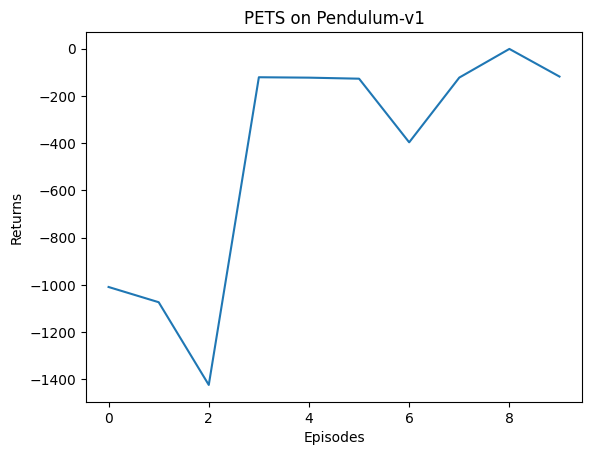

In [9]:
buffer_size = 100000
n_sequence = 50
elite_ratio = 0.2
plan_horizon = 25
num_episodes = 10
env_name = 'Pendulum-v1'
env = gym.make(env_name)

replay_buffer = ReplayBuffer(buffer_size)
pets = PETS(env, replay_buffer, n_sequence, elite_ratio, plan_horizon,
            num_episodes)
return_list = pets.train()

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PETS on {}'.format(env_name))
plt.show()

可以看出，PETS 算法的效果非常好，但是由于每次选取动作都需要在环境模型上进行大量的模拟，因此运行速度非常慢。与 SAC 算法的结果进行对比可以看出，PETS 算法大大提高了样本效率，在比 SAC 算法的环境交互次数少得多的情况下就取得了差不多的效果。